In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
# Load data
X_male = np.load("Unify_Gait_Cycles/X_male.npy")
X_female = np.load("Unify_Gait_Cycles/X_female.npy")
label_male = [[1,0]]*X_male.shape[0]
label_female = [[0,1]]*X_female.shape[0]

gait_cycles = np.append(X_male, X_female, axis=0)
labels = np.append(label_male, label_female, axis = 0)

print(gait_cycles.shape)
print(labels.shape)

(9968, 100, 4)
(9968, 2)


In [21]:
# Shuffle the data
perm = np.random.permutation(gait_cycles.shape[0])
gait_cycles = gait_cycles[perm]
labels = labels[perm]


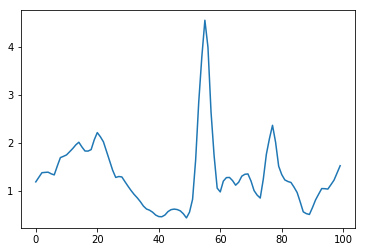

In [30]:
# Visualize the data
one_person = gait_cycles[0]
t = range(one_person.shape[0])
mag = one_person[:,3]
plt.plot(t,mag)
plt.show()